In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.3 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/.shortcut-targets-by-id/1H00NdDTisvXwJcMmLshBS2Qn7PUvkU8H/IS403/Project/Data


# Eval Function

In [5]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [7]:
def train_test_valid(data):
  test_size  = 0.3
  valid_size = 0.2

  test_split_idx  = int(data.shape[0] * (1-test_size))
  valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

  return data[:valid_split_idx], data[valid_split_idx:test_split_idx+1], data[test_split_idx+1:]

# AMAZON

## Data

In [8]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [9]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [11]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [12]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [13]:
close_amz=df_amz[['Close']]

## EDA

### Get the duration of dataset

In [14]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

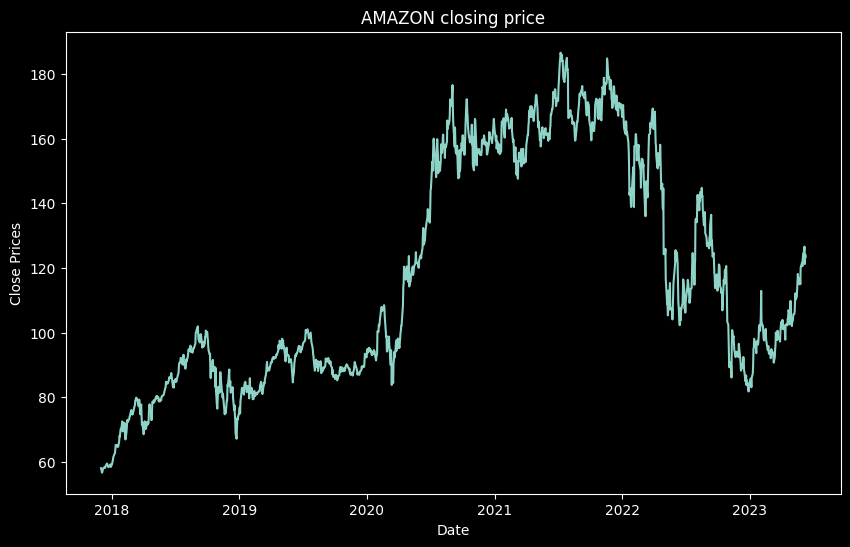

In [15]:
x_axis = np.array(df_amz['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_amz)
plt.title('AMAZON closing price')
plt.show()

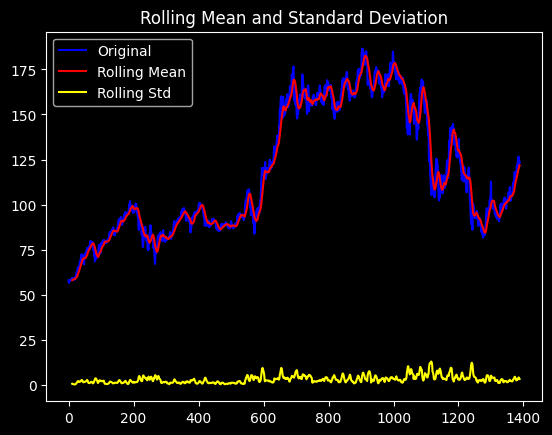

Results of dickey fuller test
Test Statistics                  -1.929368
p-value                           0.318374
No. of lags used                  0.000000
Number of observations used    1388.000000
critical value (1%)              -3.435070
critical value (5%)              -2.863625
critical value (10%)             -2.567880
dtype: float64


In [16]:
test_stationarity(close_amz)

## Train, test, valid

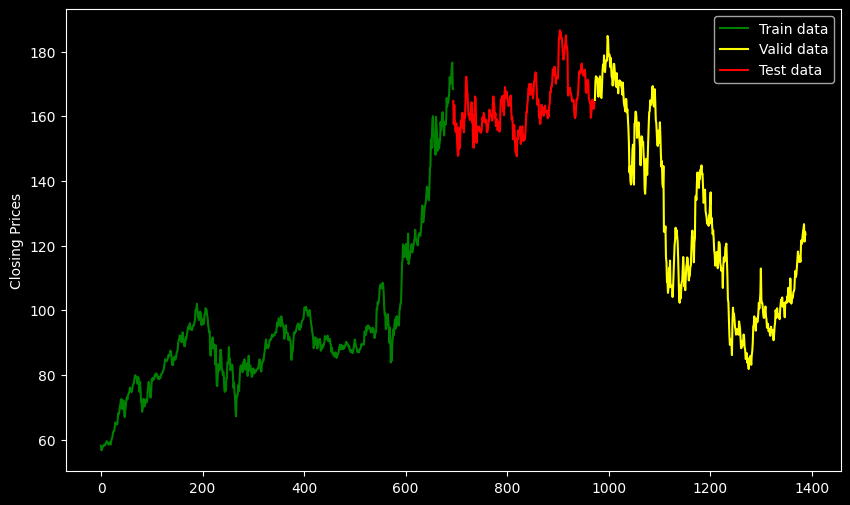

In [17]:
close_amz = close_amz.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_amz)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [18]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [19]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8315.221, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7376.544, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2938.897, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2944.540, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2940.416, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6571.080, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2941.343, Time=2.42 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2938.932, Time=3.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 8.332 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1466.448
Date:                Wed, 21 Jun 2023   AIC                           2938.897
Time:                        03:21:21   BIC                           2952.524
Sample:                             0   HQIC                          2944.167
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   3918.417      0.000       0.999       1.000
ma.L1         -0.0789      0.028     -2.830      0.005      -0.134      -0.024
sigma2         3.9601      0.124     31.926      0.000       3.717       4.203
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               473.92
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [20]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1465.527
Date:                Wed, 21 Jun 2023   AIC                           2939.053
Time:                        03:21:22   BIC                           2957.223
Sample:                             0   HQIC                          2946.080
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.4209     79.490      1.188      0.235     -61.377     250.219
ar.L1          0.9993      0.002    413.099      0.000       0.995       1.004
ma.L1         -0.0783      0.029     -2.705      0.007      -0.135      -0.022
sigma2         3.9599      0.127     31.256      0.000       3.712       4.208
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               475.10
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [21]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [22]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  8.684233045973293
MAPE:  5.254621329354921
RMSE:  10.592251276322255

** Validate **
MAE:  28.792942578714026
MAPE:  26.801202510268133
RMSE:  33.39566422012596


## Forecast

In [23]:
last_index =  close_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[141.28931062 141.25801881 141.22674789 141.19549784 141.16426867
 141.13306034 141.10187285 141.07070618 141.03956031 141.00843525
 140.97733096 140.94624744 140.91518468 140.88414265 140.85312135
 140.82212076 140.79114087 140.76018166 140.72924312 140.69832524
 140.667428   140.63655138 140.60569539 140.57485999 140.54404518
 140.51325095 140.48247728 140.45172415 140.42099155 140.39027947]


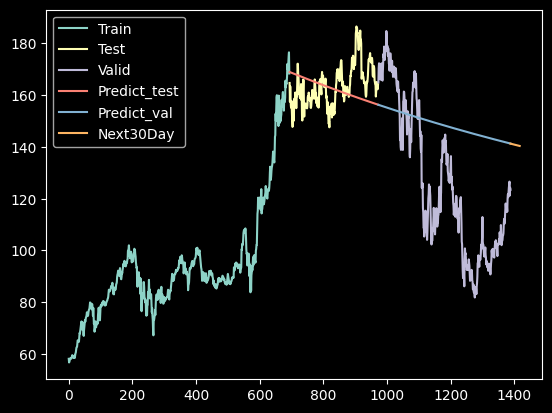

In [24]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# NVIDIA

## Data

In [25]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [26]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [27]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [28]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [29]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [30]:
close_nvda = df_nvda[['Close']]

## EDA

### Get the duration of dataset

In [31]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

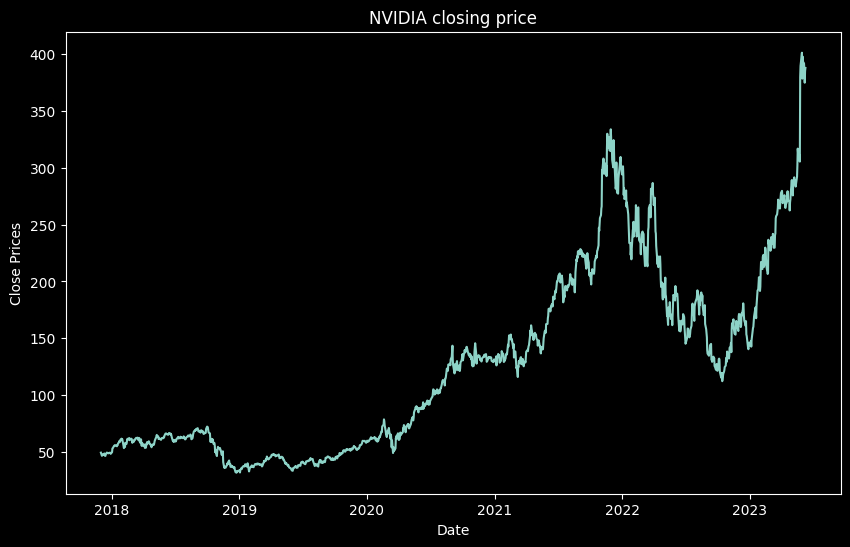

In [32]:
x_axis = np.array(df_nvda['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_nvda)
plt.title('NVIDIA closing price')
plt.show()

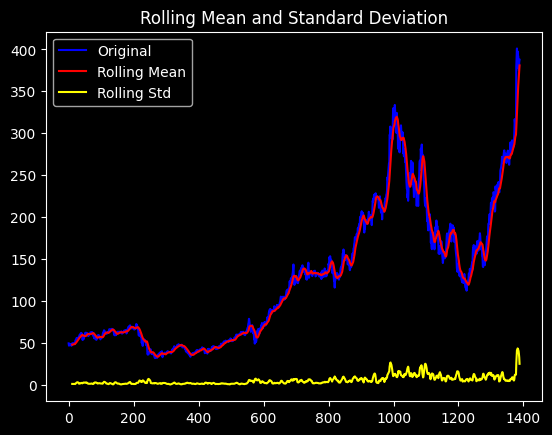

Results of dickey fuller test
Test Statistics                   0.624465
p-value                           0.988203
No. of lags used                 17.000000
Number of observations used    1371.000000
critical value (1%)              -3.435129
critical value (5%)              -2.863650
critical value (10%)             -2.567894
dtype: float64


In [33]:
test_stationarity(close_nvda)

## Train, test, valid

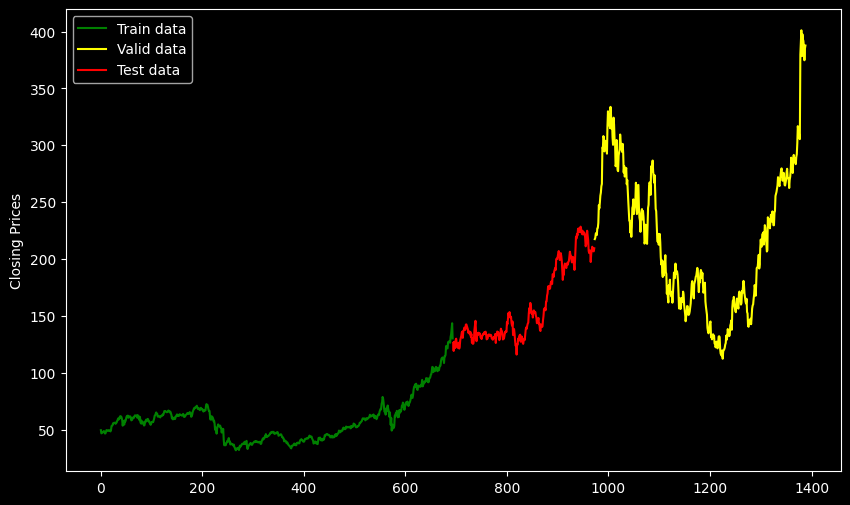

In [34]:
close_nvda = close_nvda.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_nvda)

plt.figure(figsize=(10,6))
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [35]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [36]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7698.270, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6771.712, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2869.706, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2887.126, Time=0.72 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2864.089, Time=1.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6013.224, Time=1.99 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2871.846, Time=2.98 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2865.627, Time=1.64 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5355.402, Time=3.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2860.637, Time=1.85 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2843.629, Time=1.81 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2842.071, Time=1.43 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2866.979, Time=1.56 sec
 ARIMA(4,0,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1413.980
Date:                Wed, 21 Jun 2023   AIC                           2841.959
Time:                        03:22:13   BIC                           2873.757
Sample:                             0   HQIC                          2854.256
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3227      0.658      0.491      0.624      -0.966       1.612
ar.L1         -0.7272      0.033    -22.063      0.000      -0.792      -0.663
ar.L2          0.8056      0.013     63.970      0.000       0.781       0.830
ar.L3          0.9176      0.031     29.582      0.000       0.857       0.978
ma.L1          1.6268      0.045     35.896      0.000       1.538       1.716
ma.L2          0.8049      0.044     18.208      0.000       0.718       0.891
sigma2         3.4135      0.104     32.747      0.000       3.209       3.618
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              1216.54
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [37]:
model = ARIMA(y_train, order=(3,0,2)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1414.214
Date:                Wed, 21 Jun 2023   AIC                           2842.427
Time:                        03:22:14   BIC                           2874.225
Sample:                             0   HQIC                          2854.724
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.7341     92.223      0.637      0.524    -122.020     239.489
ar.L1         -0.7269      0.032    -22.390      0.000      -0.790      -0.663
ar.L2          0.8060      0.012     64.489      0.000       0.782       0.831
ar.L3          0.9179      0.031     29.738      0.000       0.857       0.978
ma.L1          1.6267      0.045     36.311      0.000       1.539       1.715
ma.L2          0.8048      0.044     18.417      0.000       0.719       0.890
sigma2         3.4141      0.106     32.314      0.000       3.207       3.621
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):              1234.79
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [38]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [39]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  35.94520861803529
MAPE:  19.256706900093405
RMSE:  50.893920315964365

** Validate **
MAE:  109.87788166347981
MAPE:  46.20268534778974
RMSE:  126.67664910442103


## Forecast

In [40]:
last_index =  close_nvda.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[99.75770087 99.72411532 99.69055726 99.65702668 99.62352355 99.59004785
 99.55659955 99.52317864 99.48978509 99.45641888 99.42307998 99.38976838
 99.35648405 99.32322698 99.28999712 99.25679448 99.22361901 99.19047071
 99.15734954 99.12425549 99.09118853 99.05814865 99.02513581 98.99215
 98.9591912  98.92625938 98.89335452 98.8604766  98.82762559 98.79480148]


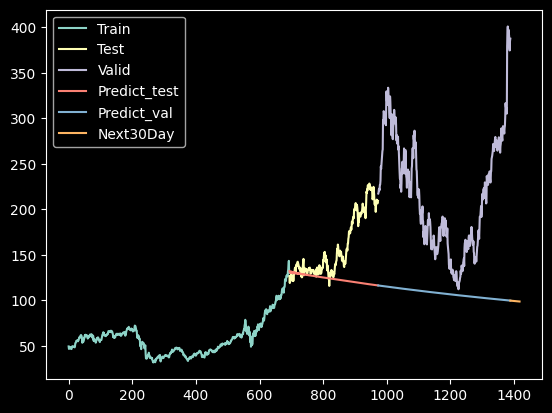

In [41]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()

# TESLA

## Data

In [42]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [43]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [44]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [45]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [47]:
close_tsla = df_tsla[['Close']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

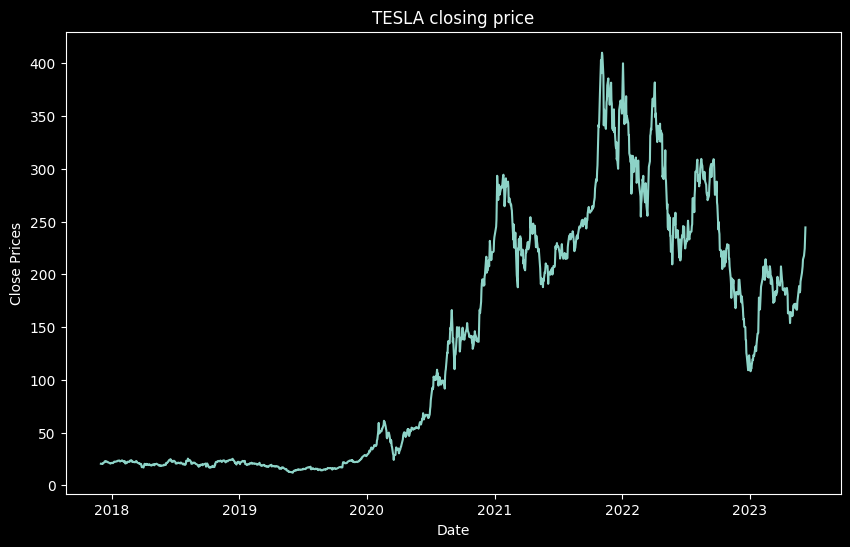

In [49]:
x_axis = np.array(df_tsla['Date'])

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(x_axis,close_tsla)
plt.title('TESLA closing price')
plt.show()

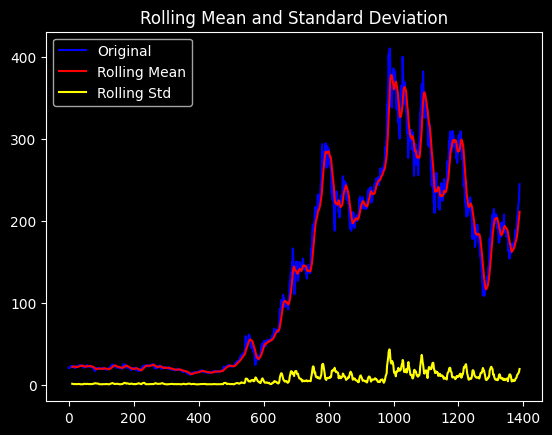

Results of dickey fuller test
Test Statistics                  -1.267376
p-value                           0.643963
No. of lags used                 24.000000
Number of observations used    1364.000000
critical value (1%)              -3.435153
critical value (5%)              -2.863661
critical value (10%)             -2.567899
dtype: float64


In [50]:
test_stationarity(close_tsla)

## Train, test, valid

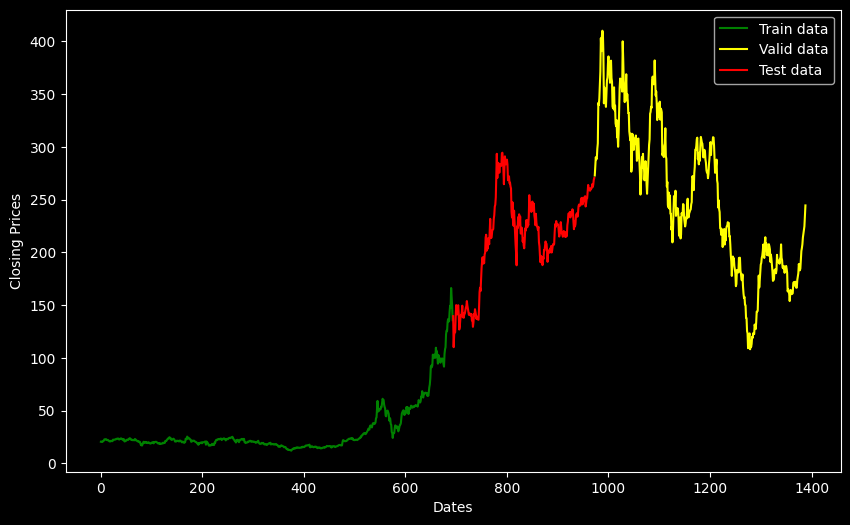

In [51]:
close_tsla = close_tsla.reset_index(drop=True)

train_data, test_data, valid_data = train_test_valid(close_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(valid_data, 'yellow', label='Valid data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

## Build model

### Choose p, q, d

In [53]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7084.873, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2997.910, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2998.952, Time=0.76 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5415.645, Time=1.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2998.710, Time=0.57 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 6.701 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1495.955
Date:                Wed, 21 Jun 2023   AIC                           2997.910
Time:                        03:22:23   BIC                           3011.538
Sample:                             0   HQIC                          3003.180
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001   1950.039      0.000       0.999       1.001
ma.L1          0.0455      0.015      2.994      0.003       0.016       0.075
sigma2         4.3162      0.073     59.495      0.000       4.174       4.458
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11369.28
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              22.47   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [54]:
model = ARIMA(y_train, order=(1,0,1)).fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  694
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1495.355
Date:                Wed, 21 Jun 2023   AIC                           2998.710
Time:                        03:22:24   BIC                           3016.880
Sample:                             0   HQIC                          3005.737
                                - 694                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.3454     58.048      1.160      0.246     -46.426     181.117
ar.L1          0.9992      0.002    536.805      0.000       0.996       1.003
ma.L1          0.0458      0.015      2.998      0.003       0.016       0.076
sigma2         4.3151      0.074     58.060      0.000       4.169       4.461
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11413.22
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              21.88   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [55]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1))


x_val= np.array(valid_data.index).reshape(-1, 1)
y_val = np.array(valid_data['Close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1))

In [56]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  87.02434711366405
MAPE:  37.434110628100456
RMSE:  97.97567769341488

** Validate **
MAE:  138.85493960035822
MAPE:  51.42630841009079
RMSE:  154.33598636231397


## Forecast

In [57]:
last_index =  close_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1))

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[105.56813553 105.53673362 105.50535751 105.47400717 105.4426826
 105.41138375 105.38011062 105.34886318 105.31764142 105.2864453
 105.25527481 105.22412993 105.19301064 105.16191692 105.13084874
 105.09980608 105.06878893 105.03779725 105.00683104 104.97589027
 104.94497492 104.91408497 104.8832204  104.85238118 104.8215673
 104.79077873 104.76001546 104.72927746 104.69856472 104.66787721]


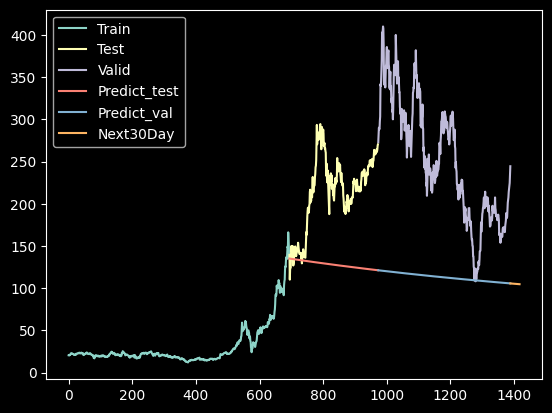

In [58]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(valid_data.index, valid_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()